# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In the previous labs, whenever it was necessary to make a decision on the "best threshold" for segmentation (like with the brown color distance), we made arbitrary decisions based on trial and error. This means that the method cannot be automated, which is always a downside.

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The optimal threshold and the Otsu threshold are two different methods to try to find the best way to split an histogram in 2 distributions.

The optimal threshold tries to maximize the distance between the centroid of the two distributions by an iterative method, while the Otsu threshold tries all possible thresholds and finds the one that maximize the inter-class variance while minimizing the intra-class variance.

Let's code both of those and apply them to the cameraman.jpg image as :

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

In [25]:
import numpy as np
# find optimal threshold in an histogram h from an initial threshold t
def optimal_threshold(h,t): #see course for details
    ''' Find the optimal threshold in an histogram h from an initial threshold t'''
    # Cut distribution in 2
    g1 = h[:t]
    g2 = h[t:]
    # Compute the centroids of the two distributions
    m1 = (g1*np.arange(0,t)).sum()/g1.sum()
    m2 = (g2*np.arange(t,len(h))).sum()/g2.sum()
    # Compute the new threshold
    t2 = int((m1+m2)/2) #round to the nearest integer
    print(m1,m2,t2)
    
    if( t2 != t ) : return optimal_threshold(h,t2) #recursive call if not the same threshold
    return t2


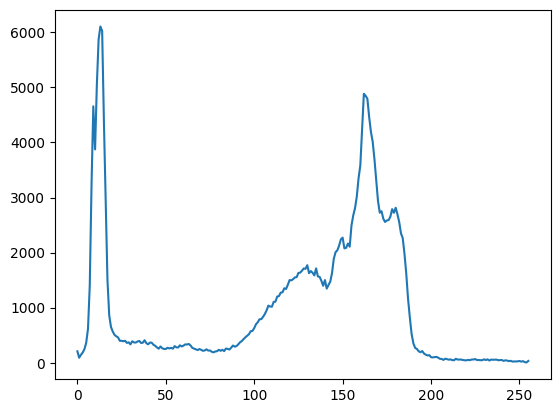

55.09594154333054 162.22702535000064 108
33.93741927471436 155.7344183588072 94
25.060352701468418 153.07614449756255 89
23.449490442192538 152.53210637767813 87
22.904349214644483 152.3350132982852 87
Optimal threshold : 87


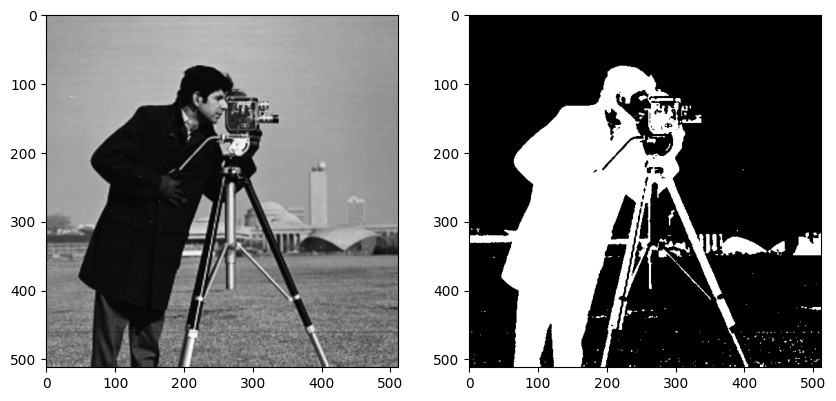

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

im = imread('camera.jpg')

## -- Your code here -- ##
h,bins = np.histogram(im,range(257))

plt.figure()
plt.plot(h)
plt.show()

t = optimal_threshold(h,128)
print("Optimal threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im<t, cmap=plt.cm.gray)
plt.show()

Now the Otsu threshold:

In [27]:
def otsu_threshold(h):
    ## -- Your code here -- ##
    p = h*1./h.sum() # Probability histogram
    
    # Check every possible threshold
    best_l = 0
    best_t = 0
    
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    for t in range(1,len(h)-1):
        # Class probabilities
        w0 = p[:t].sum()
        w1 = p[t:].sum()
        # Class means
        m0 = (np.arange(0,t)*p[:t]).sum()/w0
        m1 = (np.arange(t,len(h))*p[t:]).sum()/w1
        # Class variances
        s0 = (((np.arange(0,t)-m0)**2)*p[:t]).sum()/w0
        s1 = (((np.arange(t,len(h))-m1)**2)*p[t:]).sum()/w1
        # Intra-class
        sw = w0*s0+w1*s1
        # Inter-class
        sb = w0*w1*((m1-m0)**2)
        # Separability
        l = sb/sw
        if( l > best_l ):
            best_l = l
            best_t = t
        var_within[t] = sw
        var_between[t] = sb
        sep[t] = l
    
    return best_t, var_within, var_between, sep
    

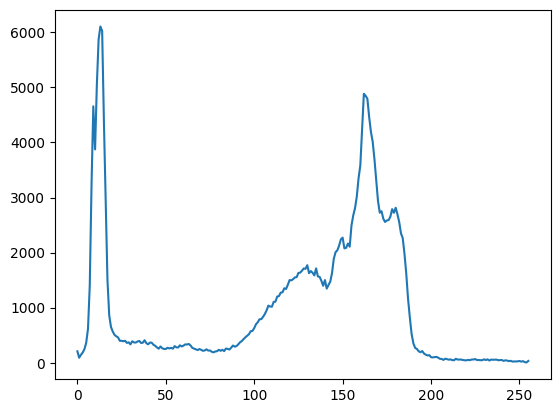

Otsu threshold : 88


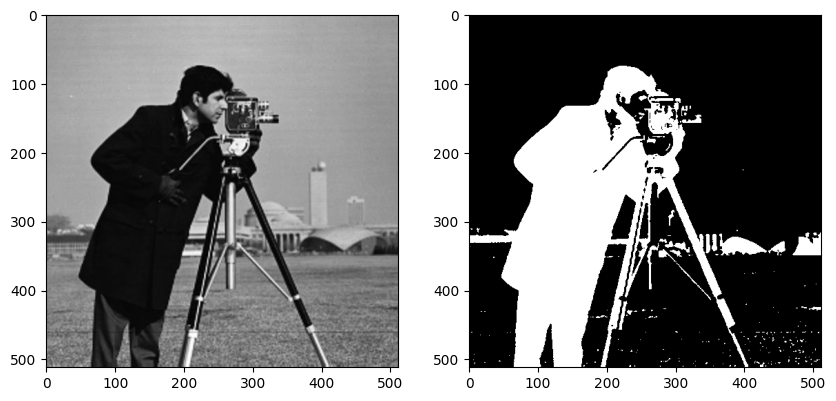

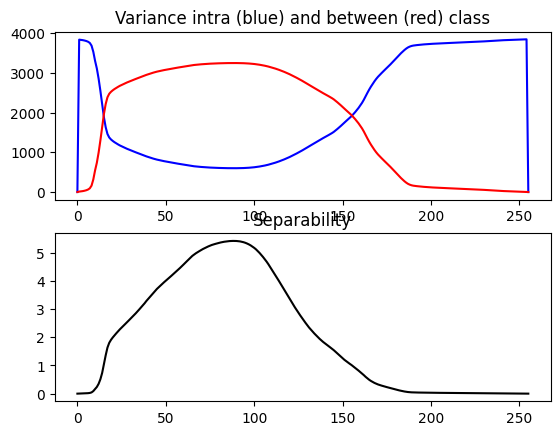

In [28]:
## -- Your code here -- ##
im = imread('camera.jpg')

h,bins = np.histogram(im,range(257))
plt.figure()
plt.plot(h)
plt.show()

t,var_within, var_between, sep = otsu_threshold(h)
print("Otsu threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im<t, cmap=plt.cm.gray)
plt.show()
plt.figure()
plt.subplot(2,1,1)
plt.plot(var_within, 'b-')
plt.plot(var_between, 'r-')
plt.title('Variance intra (blue) and between (red) class')
plt.subplot(2,1,2)
plt.plot(sep, 'k-')
plt.title('Separability')
plt.show()

Unsuprisingly, we get a very similar result to the optimal threshold. The advantage here is that we are certain that it's the best threshold (according to our criteria) as we test all possibilities, while the optimal threshold might converge into "local minima" (it's not the case with the cameraman, but it could happen with more complex histograms).

### Post-processing


Segmentation from histogram methods are almost always "noisy", in the sense that there are many small "segmented objects" in the background, and holes in the actual segmented object. Morphological operations are often used to clean up this segmentation, with opening operations to remove small objects, and closing operations to remove holes.

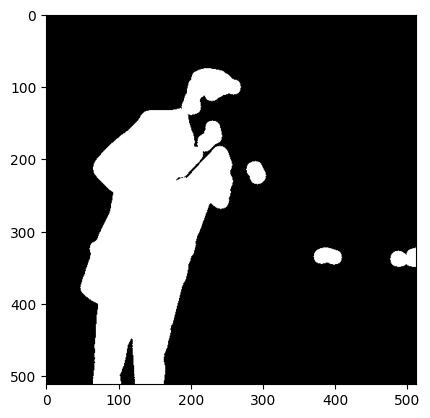

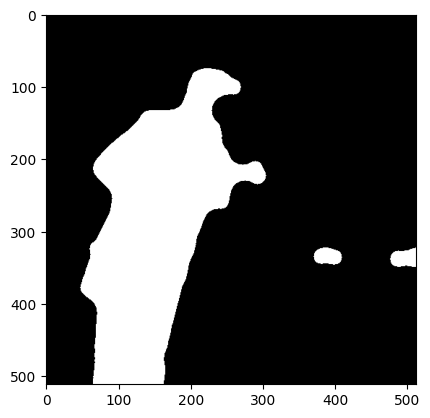

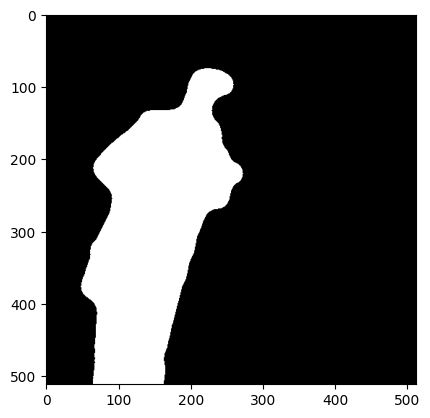

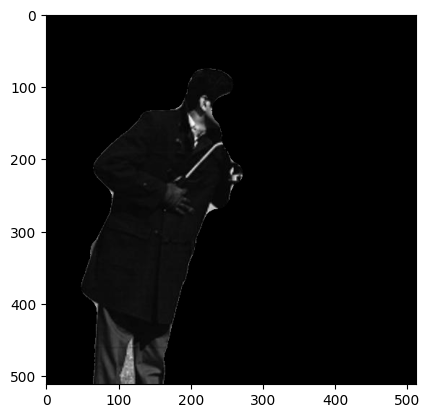

In [29]:
from skimage.morphology import disk, opening, closing

## -- Your code here -- ##
# segmented mask (we applied the threshold)
seg = im<t
# remove small objects:
seg = opening(seg, disk(10))

plt.figure()
plt.imshow(seg, cmap=plt.cm.gray)
plt.show()

# close holes inside cameraman
seg = closing(seg, disk(20))

plt.figure()
plt.imshow(seg, cmap=plt.cm.gray)
plt.show()

# remove remaining objects outside cameraman
seg = opening(seg, disk(15))
plt.figure()
plt.imshow(seg, cmap=plt.cm.gray)
plt.show()

# check on original image:
plt.figure()
plt.imshow(im*seg, cmap=plt.cm.gray)
plt.show()

**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

The problem with histogram segmentation is that it doesn't take into account the spatial distribution of the pixels. As we saw in the first lab, the histogram remains exactly the same if we shuffle the image.

Therefore, in image analysis, we will often use the concept of neighbourdhoods to characterize a pixel. If we want to perform a neigbourhood-based operation on an image, a common tactic is the "sliding window". With sliding window, we start from a corner of the image and take a neigbourhood of a certain size, on which we perform the required computations. Then, we "slide" this neighbourhood so that it covers a new (possibly overlapping) region. We keep doing that until we've gone through the entire image.

This is exactly what we did when we coded the 2D convolution. Here, instead of doing the convolution operation, we want to compute texture descriptors - in this case the dissimilarity property of the co-occurence matrix.

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

Let's take a look at the zebra image.

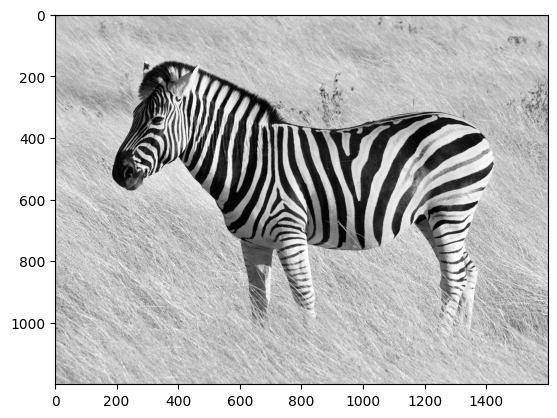

In [30]:
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage import img_as_ubyte

# Open zebra image as an 8-bit integer grayscale image
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

Whenever we want to do a sliding window, we need to decide:

The size of the patch
The "stride" by which we will move the sliding window over at each step of the algorithm
If those two values are the same, there will be no overlap between the regions. If they aren't, we will have to decide what to do about the overlap. In the kernel convolution, we used a stride of 1, and the rule was simply that we replaced the pixel at the center of the kernel by the result of the operation.

Let's start here by taking a patch size of 100x100 pixels. Our rule will be to fill the entire 100x100 pixel region with the result of the operation, which is the dissimilarity value.

Since we use the cooccurrence matrix, we need to decide of the displacement and angle. What we hope to highlight is the texture of the zebra. Let's try with an angle of 0 and a displacement of 25 pixels.

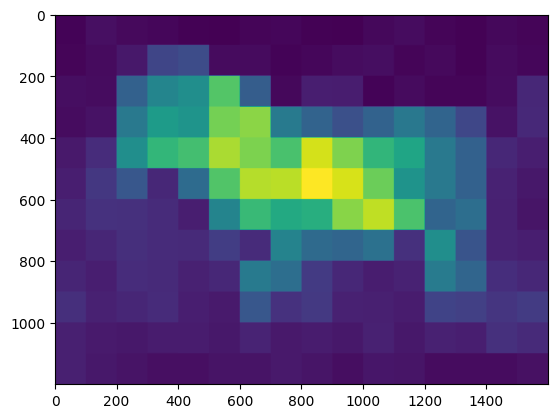

In [34]:
def texture_descriptor(N):
    ''' 
    Compute the texture descriptor of a patch N 
    '''
    displacement = 25
    angle = 0 #the glcm is computed for pixel pairs that are 25 pixels apart horizontally
    glcm = graycomatrix(N,[displacement],[angle], 256)
    return graycoprops(glcm, 'dissimilarity')[0,0] #just to get dissimilarity values

def sliding_window(im, PATCH_SIZE):
     ## -- Your code here -- ##
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output


output = sliding_window(im, (100,100))

plt.figure()
plt.imshow(output)
plt.show()


That seems like a nice start. If we change the angle, we can see that we highlight different regions of the zebra texture:

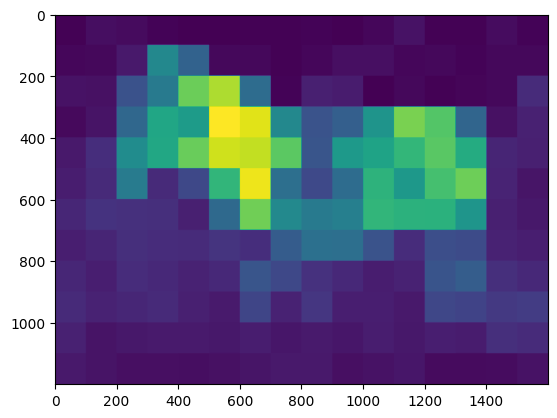

In [35]:
def texture_descriptor(N):
     ## -- Your code here -- ##
    displacement = 25
    angle = np.pi/3
    glcm = graycomatrix(N, [displacement], [angle], 256)
    return graycoprops(glcm, 'dissimilarity')[0,0]

output = sliding_window(im, (100,100))

plt.figure()
plt.imshow(output)
plt.show()

An interesting idea might be to use different angles and take the maximum value. The maximum value is useful here because we expect the zebra to have a high dissimalirity for at least one angle for this displacement in any region within it, while the background should have low dissimilarities for any angle.

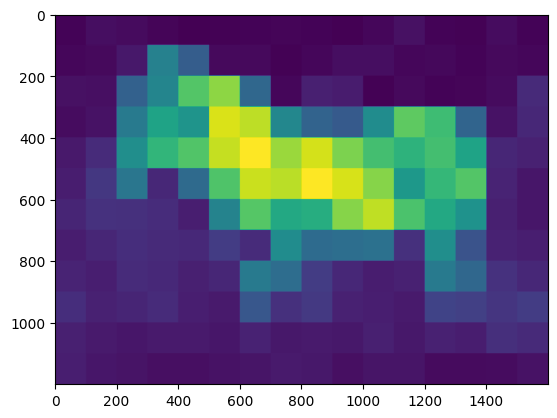

In [36]:
def texture_descriptor(N):
     ## -- Your code here -- ##
    displacement = 25
    angles = [0, np.pi/6, np.pi/4, np.pi/3]
    glcm = graycomatrix(N, [displacement], angles, 256)
    return graycoprops(glcm, 'dissimilarity').max()

output = sliding_window(im, (100,100))

plt.figure()
plt.imshow(output)
plt.show()

If we want to be a bit more precise, we can use a smaller window.

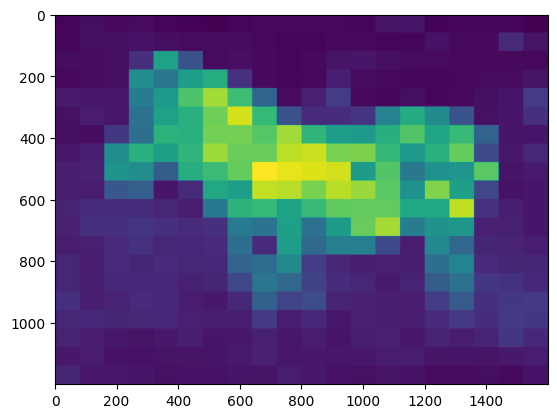

In [37]:
 ## -- Your code here -- ##
output = sliding_window(im, (60,80))

plt.figure()
plt.imshow(output)
plt.show()

A sligthly more complex (but better) option is also to add some overlap : we can use a stride that is smaller than the size of the window, and only set the result in the central region of the neighborhood:

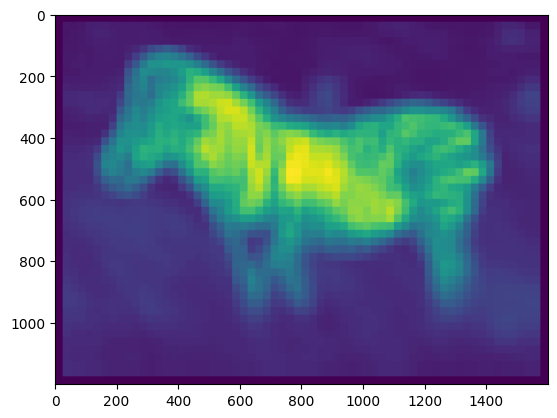

In [38]:
def sliding_window_overlap(im, PATCH_SIZE, STRIDE):
      ## -- Your code here -- ## 
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, STRIDE):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, STRIDE):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            c = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2) # center of the patch
            output[c[0]-STRIDE:c[0]+STRIDE, c[1]-STRIDE:c[1]+STRIDE] = texture_descriptor(patch)
    return output

output = sliding_window_overlap(im, (100,100), 25)

plt.figure()
plt.imshow(output)
plt.show()

We can see that the result is much better, but the more precise we want to be in the result, the more time it will take to compute. Also, our current method cannot give a prediction for the border region of the image. This could be addressed with padding (or we can just keep ignoring it).

The last step we need is to do a thresholding on the output image:

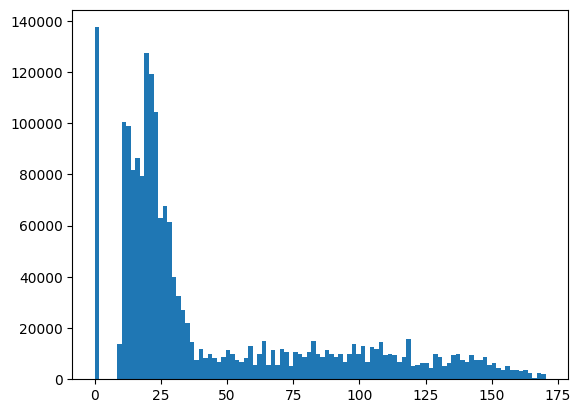

In [39]:
 ## -- Your code here -- ##
plt.figure()
plt.hist(output.flatten(), bins=100)
plt.show()

because of the 0s on the borders, the histogram has a single spike on 0. So, to obtain a better histogram ignore the borders.

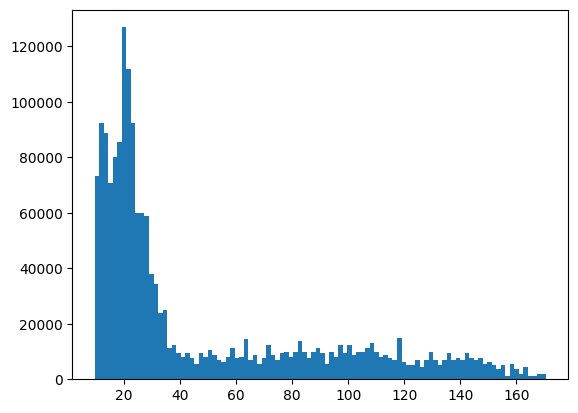

In [40]:
 ## -- Your code here -- ## 
plt.figure()
plt.hist(output[output>0].flatten(), bins=100)
plt.show()

That's better. Let's use Otsu to find the best threshold:

Best threshold: 68.30


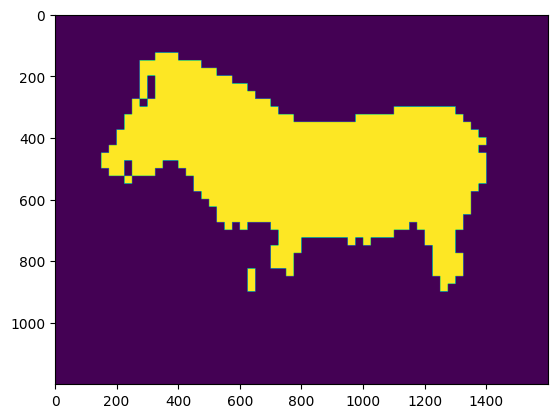

In [41]:
 ## -- Your code here -- ## 
h,bins = np.histogram(output[output>0],bins=100)
t,_,_,_ = otsu_threshold(h)

# t gives the index of the "bin" that was selected as the best threshold. If we want the actual threshold value, 
# we need to take the "center" of the bin:
t = (bins[t]+bins[t+1])/2

print("Best threshold: %.2f"%t)

plt.figure()
plt.imshow(output>t)
plt.show()

Finally, let's use this mask on the image to see what our result looks like.

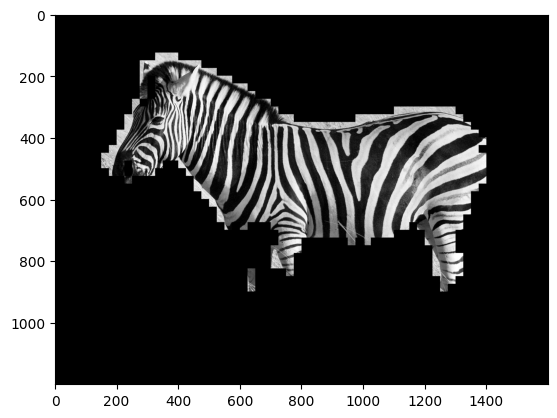

In [42]:
## -- Your code here -- ## 
mask = output>t
plt.figure()
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()

That's quite good. We could play with the treshold to have slightly better results (but with a less automated process), and we could use some morphological post-processing to clean it up and smoothen the borders:

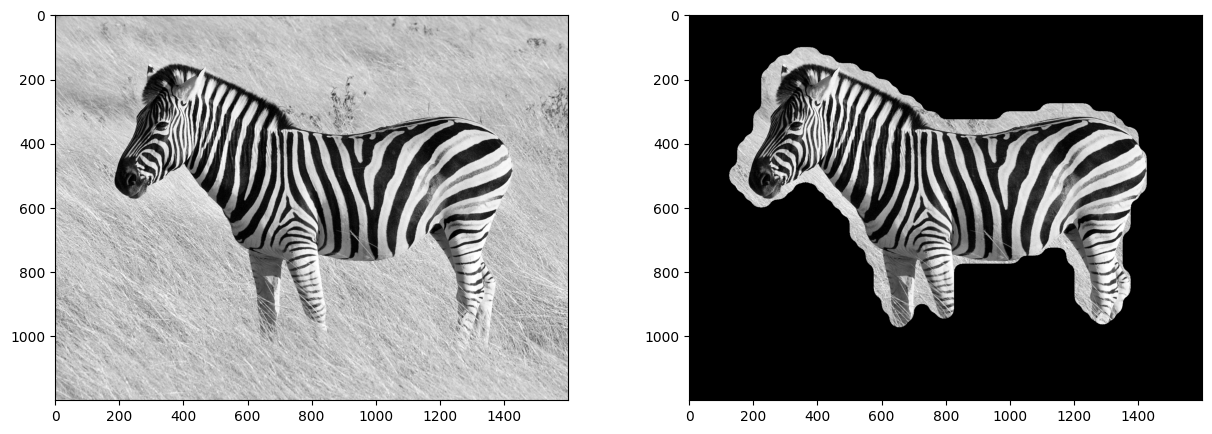

In [46]:
## -- Your code here -- ## 
from skimage.morphology import erosion
mask = opening(closing(output>40, disk(25)), disk(15))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. 

For the watershed algorithm, we need to :
1. Compute a gradient image
2. Select markers
3. Apply watershed with those markers.

The example below shows the segmentation of coins using the watershed transform:

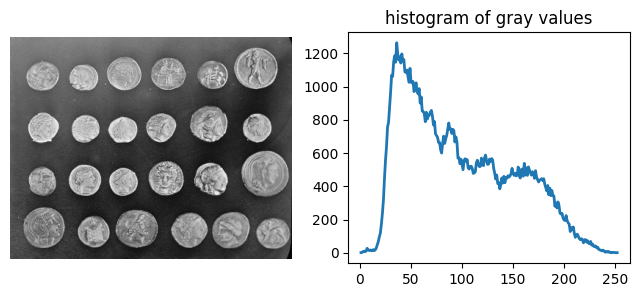

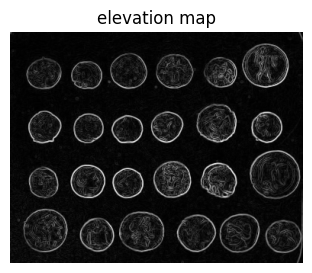

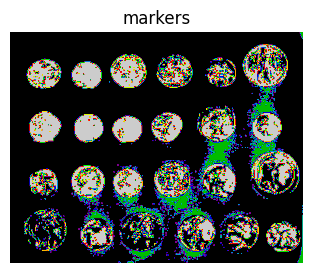

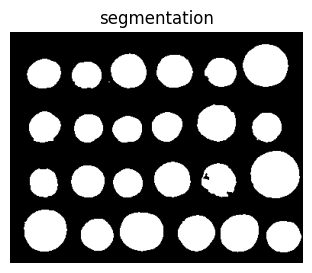

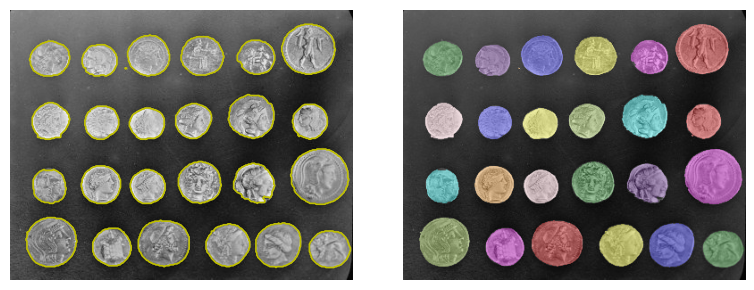

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.exposure import histogram
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
import scipy.ndimage as ndi

coins = data.coins()
hist, hist_centers = histogram(coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

#elevation map using the Sobel gradient
elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.axis('off')

#Finding markers
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral)
ax.set_title('markers')
ax.axis('off')

#Applying watershed transform
segmentation_coins = segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation_coins, cmap=plt.cm.gray)
ax.set_title('segmentation')
ax.axis('off')

#individual segmentation and labelling
segmentation_coins = ndi.binary_fill_holes(segmentation_coins - 1)
labeled_coins, _ = ndi.label(segmentation_coins)
image_label_overlay = label2rgb(labeled_coins, image=coins, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

Adapt this method to work on the camera.jpg image.

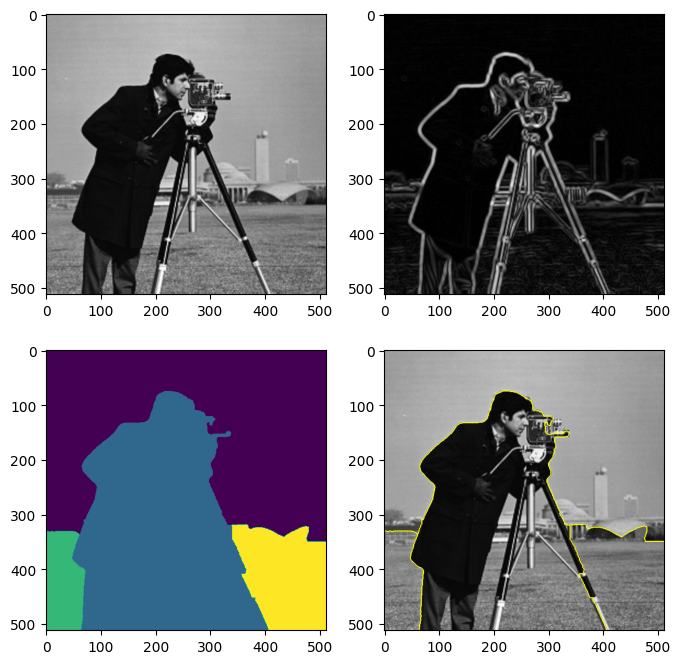

In [47]:
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread

## -- Your code here -- ## 
im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the camera image
markers_coordinates = [
    [10,256], # sky
    [200,150],# cameraman
    [400,20], # grass (left)
    [400,450] # grass (right)
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

Another use of the watershed transform is to separate overlapping object. Try implementing it on the spear.png image.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image. (Shortest distance of a pixel from the bckground, supposing the background is 0)
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3548: UserWarning: Possible precision loss converting image of type int32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\util\dtype.py:549: UserWarning: Downcasting int32 to uint8 without scaling because max value 49 fits in uint8
  return _convert(image, np.

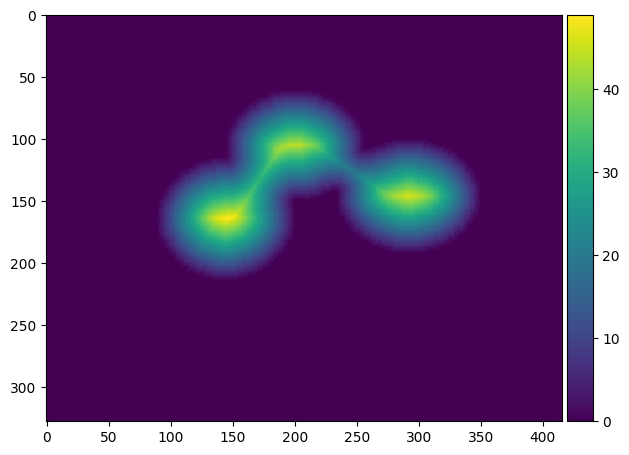

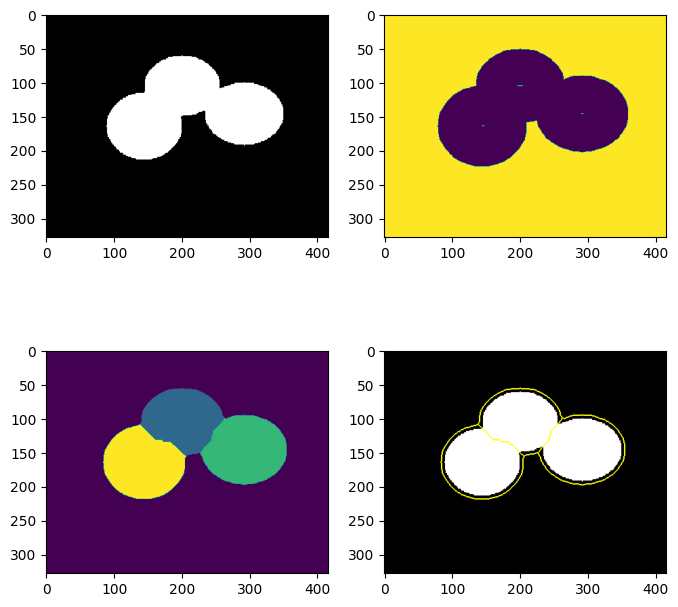

In [48]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread, imshow
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.filters import gaussian

## -- Your code here -- ##
im = rgb2gray(imread('separ.png'))==0
dist_im = distance_transform_edt(im).astype(int)
imshow(dist_im)


local_max = (dist_im == skr.maximum(dist_im,disk(10))).astype(np.uint8)
markers = label(local_max,background=0)
ws = watershed(-dist_im, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(local_max);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Using the image shapes.png try the following:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

In [ ]:
from skimage.measure import label, regionprops,find_contours
## -- Your code here -- ## 

**Shape classifier**

We can now try to create a basic shape classifier. We can, for instance, try to differentiate between :

- Triangles
- Squares
- Rectangles
- Rounded shapes
- Complex shapes

By doing a very basic decision tree :

1. Count the number of corners n.
1. If n < 3 : rounded shape
1. If n == 3 : triangle
1. If n == 4 and eccentricity (given by regionprops) ~0 : square
1. If n == 4 and eccentricity >> 0 : rectangle
1. Else : complex shape

In [ ]:
## -- Your code here -- ## 

**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

In [ ]:
from skimage.io import imread,imshow
%matplotlib inline

im = imread('mri_brain.jpg')
imshow(im)

In [ ]:

# Your code here
